# Results
Hydrodynamic derivatives regressed on all model tests are shown for the chosen VMM is shown in {numref}`fig_parameters` and {numref}`tab_parameters`. The bar plots show the mean values of these random variables together with the standard deviation shown as the black error bars.

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot, plot_parameters
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)

ship_data = catalog.load("ship_data")

2022-02-21 19:00:25,503 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-21 19:00:27,081 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-21 19:00:27,081 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-21 19:00:27,097 - root - INFO - Registered line magic `run_viz`
2022-02-21 19:00:28,196 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...


In [2]:
from sympy import latex
from scipy.stats import norm, multivariate_normal
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
import tqdm
import sys

In [3]:
#vmm_name = 'vmm_abkowitz_simple'
vmm_name = 'vmm_martins_simple'


model = catalog.load(f"{ vmm_name }.motion_regression.joined.model")
ek = catalog.load(f"{ vmm_name }.ek")

2022-02-21 19:00:28,801 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.model` (PickleDataSet)...
2022-02-21 19:00:28,878 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.ek` (ExtendedKalmanDataSet)...


In [4]:
fig_template = """```{{glue:figure}} {fig_name}
:figwidth: 800px
:name: "{fig_name}"

{caption}
```"""

In [5]:
runs_meta_data = catalog.load("runs_meta_data")
model_test_ids = [int(value) for value in model_test_ids]
mask = runs_meta_data.index.isin(model_test_ids)
runs_meta_data = runs_meta_data.loc[mask].copy()

2022-02-21 19:00:29,191 - kedro.io.data_catalog - INFO - Loading data from `runs_meta_data` (CSVDataSet)...


In [6]:
descriptions = ['ZigZag10/10','ZigZag20/20','Turning circle']
mask = runs_meta_data['description'].isin(descriptions)
runs_meta_data = runs_meta_data.loc[mask]
mask = runs_meta_data.duplicated(subset='description', keep='last')
runs = runs_meta_data.loc[~mask].copy()

2022-02-21 19:00:29,538 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.regression` (PickleDataSet)...


```{glue:figure} fig_parameters
:figwidth: 800px
:name: "fig_parameters"

Regressed parameters on vmm_martins_simple
```


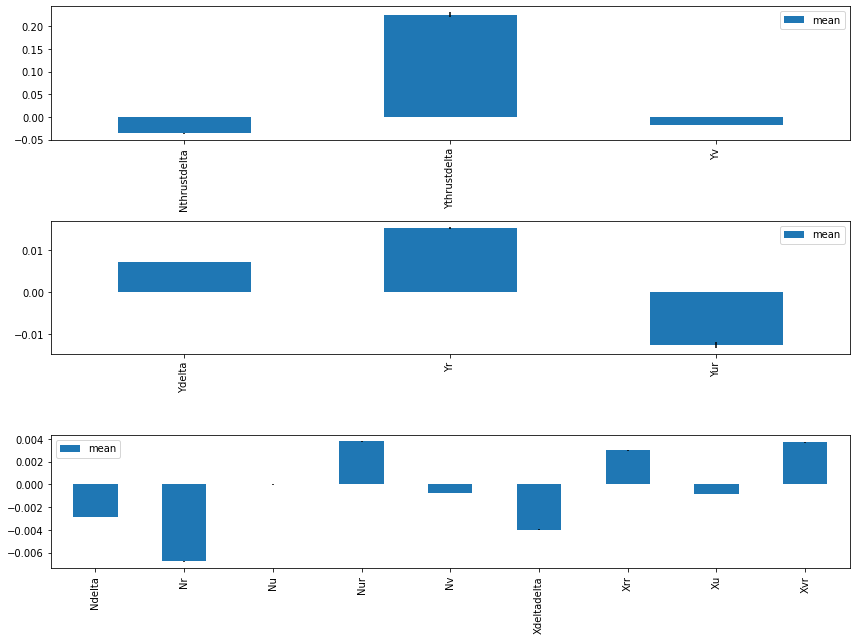

In [7]:
regression = catalog.load(f"{ vmm_name }.motion_regression.joined.regression")
    
parameters = pd.DataFrame()
parameters['mean'] = regression.parameters['regressed']
parameters['std'] = regression.std
quantile_cuts=[0.6, 0.85]
fig = plot_parameters(parameters, quantile_cuts=quantile_cuts);

fig_name = f"fig_parameters"
glue(fig_name, fig, display=False)

caption = f"Regressed parameters on {vmm_name}"
print(fig_template.format(fig_name=fig_name, caption=caption))

```{glue:figure} fig_parameters
:figwidth: 800px
:name: "fig_parameters"

Regressed parameters on vmm_abkowitz_simple
```

In [8]:
parameters['parameter'] = parameters.index
parameters['dof'] = parameters['parameter'].apply(lambda x : x[0])
parameters.sort_values(by=['parameter'], ascending=True, inplace=True)

In [9]:
keys=['parameter','mean','std']

parameters_groups = parameters.groupby(by='dof', sort=False)
dofs = ['X','Y','N']
dfs = [parameters_groups.get_group(dof).reset_index(drop=True)[keys] for dof in dofs]

table = pd.concat(dfs, axis=1)

def parameter_to_latex(x):
    s = f"$ {latex(p[x])} $"
    s = s.replace(r"\delta","delta")
    s = s.replace("delta",r"\delta")
    return s

table['parameter'] = table['parameter'].applymap(parameter_to_latex, na_action='ignore')

formatter={'mean' : "{:.5f}", 'std' : "{:.5f}"}
table_ = table.style.format(formatter=formatter, na_rep='').hide_index()

glue(f"df_parameters_{vmm_name}", table_)

parameter,mean,std,parameter,mean,std,parameter,mean,std
$ X_{\delta\delta} $,-0.00398,0.00003,$ Y_{\delta} $,0.00718,0.00002,$ N_{\delta} $,-0.00286,0.00001
$ X_{rr} $,0.00300,0.00006,$ Y_{r} $,0.01529,0.00027,$ N_{r} $,-0.00677,0.00006
$ X_{u} $,-0.00088,0.00000,$ Y_{thrust\delta} $,0.22512,0.00505,$ N_{thrust\delta} $,-0.03619,0.00126
$ X_{vr} $,0.00368,0.00007,$ Y_{u} $,-0.00001,0.00000,$ N_{u} $,-0.00001,0.00005
,,,$ Y_{ur} $,-0.01256,0.00075,$ N_{ur} $,0.00377,0.00006
,,,$ Y_{v} $,-0.01719,0.00006,$ N_{v} $,-0.00079,0.00001


In [10]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

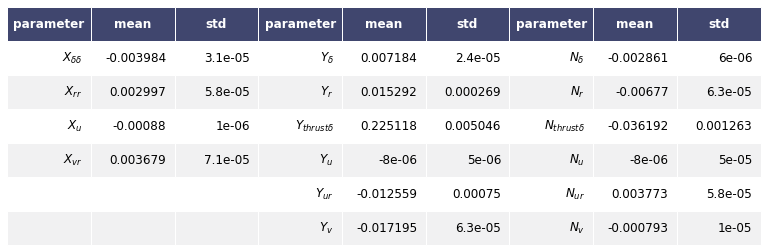

In [11]:
table_ = table.copy()
table_ = table_.round(decimals=6)
table_.fillna('', inplace=True)
fig,ax = render_mpl_table(table_, header_columns=0, col_width=1.5, font_size=12)

fig_name = f"tab_parameters"
glue(fig_name, fig, display=False)

```{glue:figure} tab_parameters
:name: "tab_parameters"

Regressed parameters on the chosen VMM, mean values and standard deviations.
```

In [12]:
def monte_carlo(data_smooth, df_parameter_variation, model, ek):

    dataframes = {}
    for index, parameters_ in df_parameter_variation.iterrows():
        model_ = model.copy()
        model_.parameters.update(parameters_)
        
        df_ = simulate_euler(data=data_smooth, model=model_,ek=ek, solver='Radau') 
        dataframes[index] = df_
        
    return dataframes

In [13]:
means = regression.parameters['regressed']
stds = regression.std

cov = regression.covs.values

rv = multivariate_normal(mean=means, cov=cov, allow_singular=True)
np.random.seed(42)
N_=10
df_parameter_variation = pd.DataFrame(data=rv.rvs(N_), columns=means.index)

In [14]:
dataframes_all = {}
vmm_names_ = [vmm_name]

dataframes_all = {}

with tqdm.tqdm(total=len(runs), file=sys.stdout) as pbar:
    for id,row in runs.iterrows():
        
        
        data_smooth = catalog.load(f"{ id }.data_ek_smooth")
        
        dataframes = dataframes_all[row['description']] = monte_carlo(data_smooth, df_parameter_variation, model=model, ek=ek)
        
        dataframes['model test'] = data_smooth
        
        for vmm_name in vmm_names_:
            data_sim = catalog.load(f"{ vmm_name }.motion_regression.joined.{ id }.data_resimulate")
            dataframes[vmm_name] = data_sim
        
        pbar.update(1)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]2022-02-21 19:00:32,408 - kedro.io.data_catalog - INFO - Loading data from `22774.data_ek_smooth` (CSVDataSet)...
2022-02-21 19:00:38,709 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
 33%|████████████████████████████                                                        | 1/3 [00:06<00:12,  6.34s/it]2022-02-21 19:00:38,744 - kedro.io.data_catalog - INFO - Loading data from `22769.data_ek_smooth` (CSVDataSet)...
2022-02-21 19:00:42,782 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22769.data_resimulate` (CSVDataSet)...
 67%|████████████████████████████████████████████████████████                            | 2/3 [00:10<00:04,  4.99s/it]2022-02-21 19:00:42,794 - kedro.io.data_catalog - INFO - Loading data from `22772.data_ek_smooth`

In [15]:
styles={'model test':{'style':'k-'},
       'VMM':{'style':'r-'},
       }

for index, parameters_ in df_parameter_variation.iterrows():
    styles[index] = {'style':'b-', 
                     'alpha':0.3,
                     'label':'_Hidden label'}

```{glue:figure} fig_track_plot_Turning circle
:figwidth: 800px
:name: "fig_track_plot_Turning circle"

Track plot Turning circle model test and simulations with vmm_martins_simple
```


```{glue:figure} plot_Turning circle
:figwidth: 800px
:name: "plot_Turning circle"

Time series Turning circle model test and simulation with vmm_martins_simple
```


```{glue:figure} fig_track_plot_ZigZag10/10
:figwidth: 800px
:name: "fig_track_plot_ZigZag10/10"

Track plot ZigZag10/10 model test and simulations with vmm_martins_simple
```


```{glue:figure} plot_ZigZag10/10
:figwidth: 800px
:name: "plot_ZigZag10/10"

Time series ZigZag10/10 model test and simulation with vmm_martins_simple
```


```{glue:figure} fig_track_plot_ZigZag20/20
:figwidth: 800px
:name: "fig_track_plot_ZigZag20/20"

Track plot ZigZag20/20 model test and simulations with vmm_martins_simple
```


```{glue:figure} plot_ZigZag20/20
:figwidth: 800px
:name: "plot_ZigZag20/20"

Time series ZigZag20/20 model test and simulation with vmm_martins_simple
```


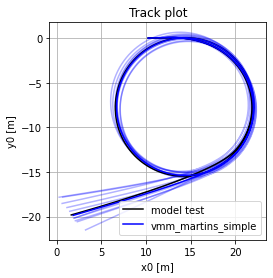

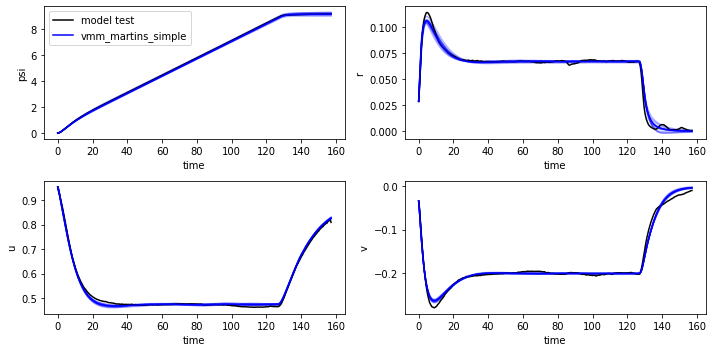

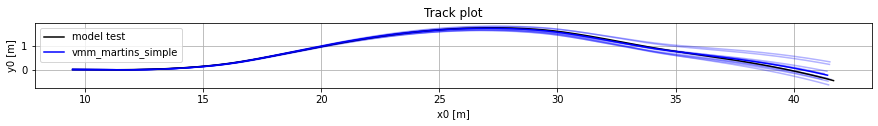

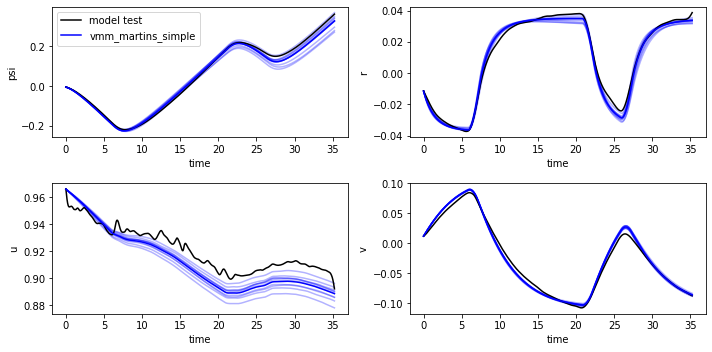

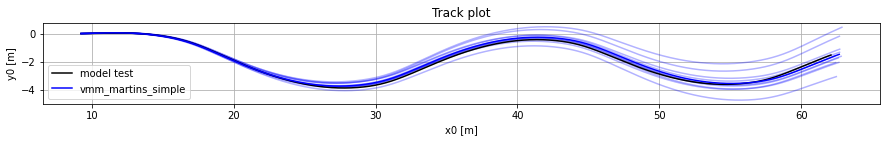

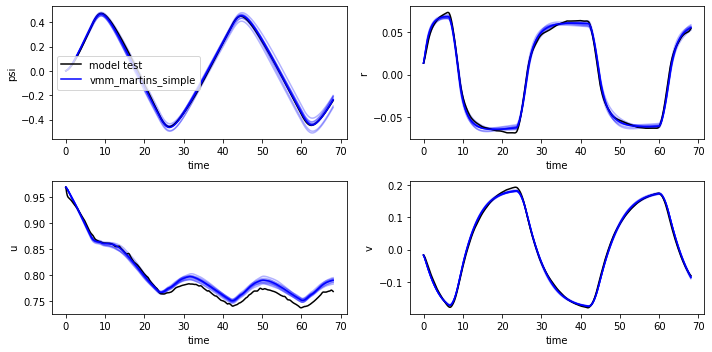

In [16]:
for description, dataframes in dataframes_all.items():
    
    ax = track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'], plot_boats=False, flip=True, 
                     styles=styles)
    fig = ax.get_figure()
    fig_name = f"fig_track_plot_{description}"
    caption = f"Track plot {description} model test and simulations with {vmm_name}"
    glue(fig_name, fig, display=False)
    print(fig_template.format(fig_name=fig_name, caption=caption))
    
    fig = plot(dataframes, keys=['psi','u','v','r'], fig_size=(10, 5), styles=styles)
    fig_name = f"plot_{description}"
    caption = f"Time series {description} model test and simulation with {vmm_name}"
    glue(fig_name, fig, display=False)
    print(fig_template.format(fig_name=fig_name, caption=caption))

A selection of simulations with the chosen VMM fitted on all model tests is shown for ZigZag10/10, ZigZag20/20 and Turning circle in {numref}```fig_track_plot_ZigZag10/10```, {numref}```fig_track_plot_ZigZag10/10```. 
The simulation with the most likely parameters (mean values from the regression) is shown as blue lines to be compared with corresponding values from the model test in black.
Also results from simulations with alternative realizations of the regression are shown as transparent blue lines. These alternative realizations have been sampled from a multivariate normal distribution with mean values and covariance matrix from the regression.   

```{glue:figure} fig_track_plot_Turning circle
:figwidth: 800px
:name: "fig_track_plot_Turning circle"

Track plot Turning circle model test and simulations with vmm_martins_simple
```
```{glue:figure} plot_Turning circle
:figwidth: 800px
:name: "plot_Turning circle"

Time series Turning circle model test and simulation with vmm_martins_simple
```
```{glue:figure} fig_track_plot_ZigZag10/10
:figwidth: 800px
:name: "fig_track_plot_ZigZag10/10"

Track plot ZigZag10/10 model test and simulations with vmm_martins_simple
```
```{glue:figure} plot_ZigZag10/10
:figwidth: 800px
:name: "plot_ZigZag10/10"

Time series ZigZag10/10 model test and simulation with vmm_martins_simple
```
```{glue:figure} fig_track_plot_ZigZag20/20
:figwidth: 800px
:name: "fig_track_plot_ZigZag20/20"

Track plot ZigZag20/20 model test and simulations with vmm_martins_simple
```
```{glue:figure} plot_ZigZag20/20
:figwidth: 800px
:name: "plot_ZigZag20/20"

Time series ZigZag20/20 model test and simulation with vmm_martins_simple
```

In [17]:
id = 22774
dataframes={}
#vmm_name = 'vmm_martins_simple'
#vmm_name = 'vmm_abkowitz_simple'

regression2 = catalog.load(f"{ vmm_name }.motion_regression.no_circle.regression")

2022-02-21 19:00:55,125 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.no_circle.regression` (PickleDataSet)...


In [18]:
means = regression2.parameters['regressed']
stds = regression2.std

cov = regression2.covs.values

rv2 = multivariate_normal(mean=means, cov=cov, allow_singular=True)
np.random.seed(42)
N_=20
df_parameter_variation2 = pd.DataFrame(data=rv2.rvs(N_), columns=means.index)

In [19]:
df_smooth = catalog.load(f"{ id }.data_ek_smooth")
dataframes = monte_carlo(df_smooth, df_parameter_variation2, model=model, ek=ek)

2022-02-21 19:00:55,486 - kedro.io.data_catalog - INFO - Loading data from `22774.data_ek_smooth` (CSVDataSet)...


2022-02-21 19:01:18,597 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-21 19:01:18,631 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...


```{glue:figure} fig_track_plot_hold_out
:figwidth: 800px
:name: "fig_track_plot_hold_out"

Track plot for model test and simulations with VMM fitted on all data and all data except turning circle
```


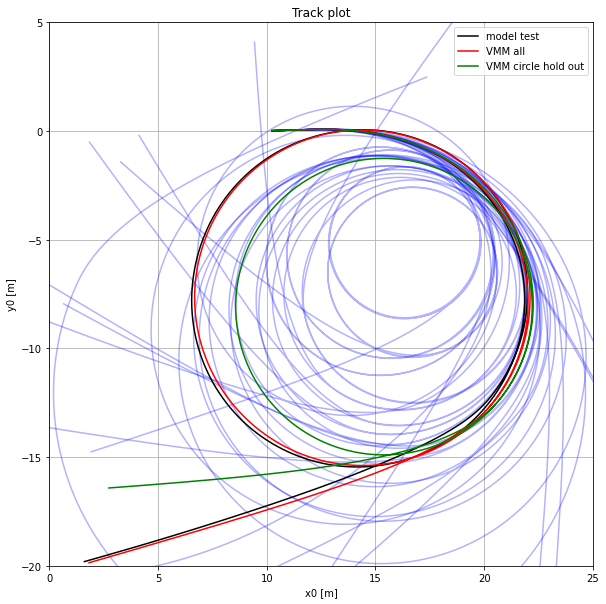

In [20]:
dataframes['model test'] = df_smooth
dataframes['VMM all'] = catalog.load(f"{ vmm_name }.motion_regression.joined.{ id }.data_resimulate")
dataframes['VMM circle hold out'] = catalog.load(f"{ vmm_name }.motion_regression.no_circle.{ id }.data_resimulate")

styles={'model test':{'style':'k-'},
       'VMM all':{'style':'r-'},
       'VMM circle hold out':{'style':'g-'},
        
       }

for index, parameters_ in df_parameter_variation2.iterrows():
    styles[index] = {'style':'b-', 
                     'alpha':0.3,
                     'label':'_Hidden label'}

fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'], plot_boats=False, flip=True, N=7, styles=styles, ax=ax)
#ax.set_xlim((dataframes['model test']['x0'].min(), dataframes['model test']['x0'].max()))
#ax.set_ylim((-dataframes['model test']['y0'].max(), dataframes['model test']['y0'].min()))

ax.set_xlim(0,25)
ax.set_ylim(-20,5)

fig = ax.get_figure()
fig_name = f"fig_track_plot_hold_out"
caption = f"Track plot for model test and simulations with VMM fitted on all data and all data except turning circle"
glue(fig_name, fig, display=False)
print(fig_template.format(fig_name=fig_name, caption=caption))
       

```{glue:figure} fig_track_plot_hold_out
:figwidth: 800px
:name: "fig_track_plot_hold_out"

Track plot for model test and simulations with VMM fitted on all data and all data except turning circle
```